In [57]:
import numpy as np
from project.domain_visualizer import CubeDomain
from enum import Enum

class transpStat(Enum):
    X_CONT = 0
    Y_CONT = 1
    Z_CONT = 2
    
    
domain = CubeDomain()
colors = ['blue', 'green', 'red', 'yellow']

In [58]:
def get_order_by_transpStat(stat, x, y, z):
    if stat == transpStat.X_CONT:
        return x, y, z
    if stat == transpStat.Y_CONT:
        return y, z, x 
    if stat == transpStat.Z_CONT:
        return z, x, y 

In [59]:
def visualize_ranks(stat):
    for z in range(4):
        for y in range(4):
            for x in range(4):
                x_t, y_t, z_t = get_order_by_transpStat(stat, x, y, z)
                domain.set_cube_color(x_t, y_t, z_t, colors[z])
                
    domain.plot_wireframe(show_cells=True, show_cubes=True)

General visualization of domain throughout transposition steps:
X-contiguous, data split along z-axis:


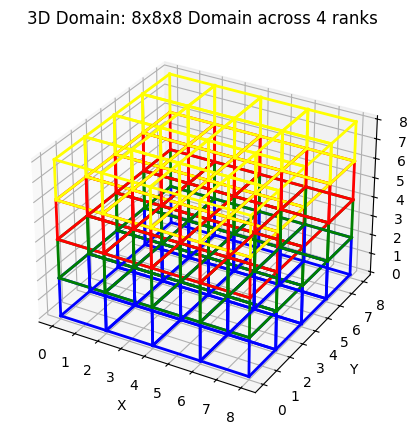

Y-contiguous, data split along x-axis:


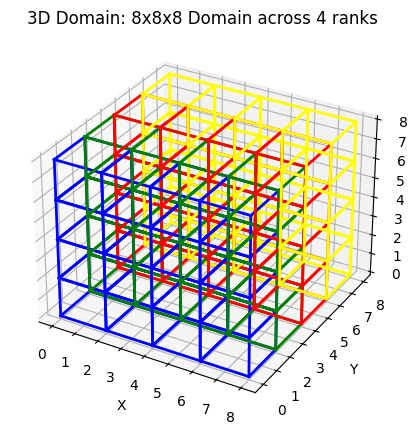

Z-contiguous, data split along y-axis:


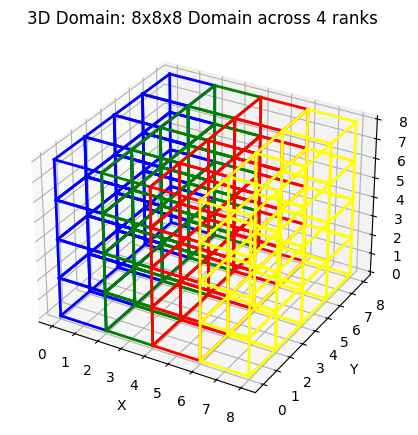

In [60]:
print("General visualization of domain throughout transposition steps:")
print("X-contiguous, data split along z-axis:")
visualize_ranks(transpStat.X_CONT)
print("Y-contiguous, data split along x-axis:")
visualize_ranks(transpStat.Y_CONT)
print("Z-contiguous, data split along y-axis:")
visualize_ranks(transpStat.Z_CONT)

X-cont, after first [planes_per_rank] ffts which can be executed as a batch, the first XZ plane will be ready


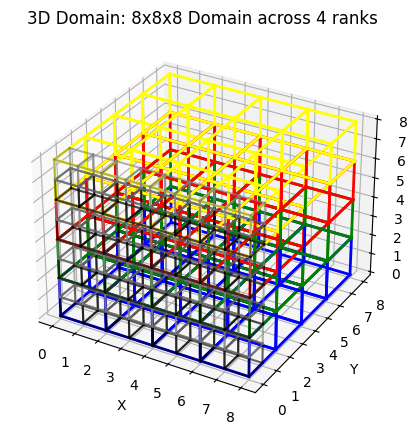

This plane can already be sent to the next work buffer which will be Z-Cont


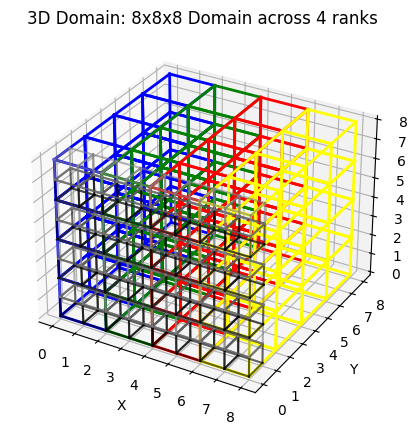

In [61]:
# Idea: The first pencils could already get transformed while the other ffts are still running
# First plane needs to be done:
def visualize_plane(stat):
    for z in range(4):
        for y in range(4):
            for x in range(4):
                x_t, y_t, z_t = get_order_by_transpStat(stat, x, y, z)
                domain.set_cube_color(x_t, y_t, z_t, colors[z])
                for c_z in range(2):
                    for c_y in range(2):
                        for c_x in range(2):
                            c_x_t, c_y_t, c_z_t = get_order_by_transpStat(stat, c_x, c_y, c_z)
                            if y_t == 0 and c_y_t == 0:
                                color = 'grey' if c_z_t == 1 else 'black'
                                domain.set_cell_color(x_t, y_t, z_t, c_x_t, c_y_t, c_z_t, color)
                
    domain.plot_wireframe(show_cells=True, show_cubes=True)
    

print("X-cont, after first [planes_per_rank] ffts which can be executed as a batch, the first XZ plane will be ready")
visualize_plane(transpStat.X_CONT)
print("This plane can already be sent to the next work buffer which will be Z-Cont")
visualize_plane(transpStat.Z_CONT)

In [62]:
# Pipeline/ Streaming approach

# 1. Complete all fft operations on data with x = 0 (-> The data required for the first plane of z-contiguous)
# 2. Reorganize only these pencils into send buffer
# 3. Send to target rank receive buffer
# 4. Target rank receives data from every rank and is therefore able to reorganize data into first z-contiguous plane
# 5. Complete all fft operations on data with z = 0 (-> The data required for )